In [1]:
%matplotlib inline
#Codes by Shucheng Yang
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pycbc.psd

from pycbc.types.timeseries import TimeSeries
from pycbc.types.frequencyseries import FrequencySeries
from pycbc import filter



from astropy import constants as const #import constants 
import astropy.units as u              #import unit

from scipy.interpolate import interp1d #导入scipy库
import os
import time

def file2series(path):
    with open(path, 'r') as f:
        datafile = f.readlines()

    datafile = [np.fromstring(item.replace("D","e").replace('\n','').strip(), dtype= float, sep =' ') for item in datafile]
    datafile = np.array(datafile)
    ans = {}
    
    ans['timeVec'] = datafile[:,0]
    ans['n'] = len(ans['timeVec'])
    ans['sampIntrvl'] = ans['timeVec'][1]-ans['timeVec'][0]
    
    ans['hp'] = TimeSeries( datafile[:,5], delta_t=ans['sampIntrvl'], dtype = float,copy=True)
    ans['hc'] = TimeSeries( datafile[:,6], delta_t=ans['sampIntrvl'], dtype = float,copy=True)    
    return ans


#绘制波形图
def plotwave(hp,hc):
    plt.figure(figsize=(8,8/1.5))
    plt.plot(hp.sample_times, hp, label = '$h_{+}$')
    plt.plot(hc.sample_times, hc, label = '$h_{\\times}$')
    # plt.xlim(40,40.5)
    # plt.ylim(- 2e-22,2e-22)
    plt.xlabel("Time / s")
    plt.ylabel("$Strain$")
    plt.legend()
    plt.tight_layout()
    plt.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
    plt.show()


def stdf(h, f_max, freqIntrvl):
    #interp1d
    hf = h.to_frequencyseries()    
    freqVec = hf.sample_frequencies
    hf_value = np.array(hf)
    fit=interp1d(freqVec, hf_value,fill_value = "extrapolate")  
    #
    stdFreqVec = np.arange(0, f_max, freqIntrvl)
    hf_value_std = fit(stdFreqVec)
    stdf_series = pycbc.types.frequencyseries.FrequencySeries(hf_value_std, delta_f=freqIntrvl, epoch='', copy=True)
    return stdf_series


def overlap_match_func(hf1, hf2, psd, f_min, f_max):
    roverlap = filter.matchedfilter.overlap(hf1, hf2, psd=psd, low_frequency_cutoff=f_min , high_frequency_cutoff=f_max, normalized=True)  
    amplitude1 = filter.matchedfilter.sigmasq(hf1, psd=psd, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max )
    amplitude2 = filter.matchedfilter.sigmasq(hf2, psd=psd, low_frequency_cutoff=f_min, high_frequency_cutoff=f_max )
    rmatch,nn =filter.matchedfilter.match(hf1, hf2, psd=psd, low_frequency_cutoff=f_min , high_frequency_cutoff=f_max,v1_norm=True ,v2_norm=True)
    rmatch = rmatch / np.sqrt(amplitude1 * amplitude2)
    return roverlap, rmatch

def compare_multi(path1, path2):
    #path1 
    ans = file2series(path1)
    hp1 = ans["hp"]
    hc1 = ans["hc"]
    timeVec1 = ans["timeVec"]
    n1 = ans["n"]
    sampIntrvl1 = ans["sampIntrvl"]

    #path2
    path2file = path2.replace("/home/ysc/Desktop/nw2/","")
    anu = path2file.replace("hbh60_NS14_a","").replace("_f10Hz_fisco.dat","").split("_nu")
    a = float("0." + anu[0]) 
    nu = float("0.0" +anu[1])
    
    
    ans = file2series(path2)
    hp2 = ans["hp"]
    hc2 = ans["hc"]
    timeVec2 = ans["timeVec"]
    n2 = ans["n"]
    sampIntrvl2 = ans["sampIntrvl"]

    assert sampIntrvl1 == sampIntrvl2 
    n_min = min(n1,n2)
    
    
    sampFreq = 1/sampIntrvl1#1450             #采样频率(Sampling frequency)，单位时间样本点个数，应大于 2f（即Nyquist频率)
    duration = n_min/sampFreq #40        #信号持续时间(duration of signal) 2^16, 0.75d, 2^25 ,1.06yr

    n = int(duration * sampFreq)#采样点数(Sampling Number), 有时也称为信号长度(Length of Signal) 2^16
                                #为2的幂时，快速傅里叶变化效率最高
                                #n =  duration * sampFreqint = (duration / sampIntrvl)

#     sampIntrvl = 1.0 / sampFreq                   #采样周期(Sampling period)，隔多少时间取样一次，或步长
    freqIntrvl = sampFreq / n                     #傅里叶变换 频率分辨率(Frequency Interval) 
                                                  # freqIntrvl = 1 / duration = 1 / (n * sampIntrvl)
                                                  #            = sampFreq / n  

    f_min = 20              #低于此频率的psd将被设置为0
    f_max = sampFreq/2             #信号模式的最大频率

    #示例，psd参见， https://dcc.ligo.org/LIGO-T1800044/public
    psd = pycbc.psd.from_string('aLIGOaLIGODesignSensitivityT1800044', n , freqIntrvl, f_min)


    hpf1 = stdf(hp1, f_max, freqIntrvl)
    hpf2 = stdf(hp2, f_max, freqIntrvl)

    hcf1 = stdf(hc1, f_max, freqIntrvl)
    hcf2 = stdf(hc2, f_max, freqIntrvl)

    overlap_hp, match_hp = overlap_match_func(hpf1, hpf2, psd, f_min, f_max)
    overlap_hc, match_hc = overlap_match_func(hcf1, hcf2, psd, f_min, f_max)

    return a, nu, match_hp, match_hc, overlap_hp, overlap_hc

In [2]:
# #uni
# time0 = time.time()
 
# path1 = "/home/ysc/Desktop/nw1/heco60_NS14_a60s50_R9_nu250_f10Hz_fisco.dat"  #compare against 1

# dirs2 = os.listdir("/home/ysc/Desktop/nw2/")
# path2 = "/home/ysc/Desktop/nw2/" + dirs2[0]  #compare n

# ans = compare_multi(path1, path2)
# timet = time.time()
# print("cost %4.2f s"%(timet-time0))
# print(ans)

In [3]:
#multi
time0 = time.time()
 
path1 = "/home/ysc/Desktop/nw1/heco60_NS14_a60s50_R9_nu250_f10Hz_fisco.dat"  #compare against 1
dirs2 = os.listdir("/home/ysc/Desktop/nw2/")

anslist = []

for item in dirs2:
    try:
        path2 = "/home/ysc/Desktop/nw2/" + item  #compare n
        ans = compare_multi(path1, path2)
        print(ans)
        anslist.append(ans)
    except Exception:
        print(item)
        
timet = time.time()
print("cost %4.2f s"%(timet-time0))

ansarray = np.array(anslist)


#按照顺序输出
anslist2 = sorted(anslist)

with open("a_nu_match_hp_hc_overlap_hp_hc.data", "w") as f:
    for item in anslist2:
        print(item[0],item[1],item[2],item[3],item[4],item[5], file = f)

(0.51, 0.025, 0.2983004708765069, 0.2953145428539898, 0.01930663456365117, 0.019803567380668363)
(0.56, 0.0385, 0.16977897849864618, 0.16587084767240348, -0.029511463378819523, -0.03409246248186078)
(0.67, 0.01, 0.0741315455834759, 0.0725970379607887, -0.010051173030938942, -0.012635435270908824)
(0.69, 0.0235, 0.21110934513257712, 0.20892379923130527, 0.02104179316987456, 0.022594086888507132)
(0.68, 0.0145, 0.10076602470360549, 0.09898606220548697, -0.015270032410679268, -0.017980813599782857)
(0.52, 0.013, 0.14545176651030706, 0.14391048606918702, -0.13525648334900173, -0.13535016569818914)
(0.62, 0.019, 0.16798233059514897, 0.16513511295608616, -0.04383186872081609, -0.04748075307191805)
(0.56, 0.0325, 0.19171470324764311, 0.196907763344665, 0.05611950685595773, 0.05245991898708848)
(0.61, 0.0145, 0.11832896668256164, 0.11624900124050808, -0.0411869353959129, -0.04287808231385616)
(0.55, 0.04, 0.16060909462652492, 0.15757811219270604, -0.042958509449191606, -0.04497885819279588)
(0

(0.59, 0.013, 0.11111530494351836, 0.1089872772839689, -0.05709366194549229, -0.05989683247706089)
(0.68, 0.0295, 0.47056833918967794, 0.47305439561405216, -0.2614303375398397, -0.26364737159633317)
(0.5, 0.0205, 0.43600422881285944, 0.4338258469783786, -0.26977912615387284, -0.2695618133082844)
(0.69, 0.0295, 0.4981712823356242, 0.4984086524001637, -0.18781647365273108, -0.1849891099074644)
(0.51, 0.0145, 0.17979767281768666, 0.18061573089403843, 0.10089790528642367, 0.10174823789838339)
(0.5, 0.0325, 0.16322946607776279, 0.16743999262135223, 0.027863590367134778, 0.023556015686502913)
(0.57, 0.016, 0.1526917575923745, 0.15038134349763965, 0.003929037652621727, 0.0032732609329261023)
(0.57, 0.019, 0.21074152996327494, 0.2078864074076792, 0.14365359727302435, 0.14572678162083463)
(0.61, 0.028, 0.3484685079420984, 0.3440660343558687, 0.2579772337747023, 0.25949660361031374)
(0.63, 0.0205, 0.18598740771855846, 0.18325246366901887, 0.05443167297135145, 0.05621113912872832)
(0.65, 0.0205, 

(0.51, 0.028, 0.20648675500412011, 0.21002119416641926, 0.032113023781265085, 0.029210585282216036)
(0.51, 0.0325, 0.17024270746613182, 0.1698565683802349, -0.01874079811268312, -0.015016947741015462)
(0.64, 0.0385, 0.20676300830819208, 0.2100883132074604, -0.15123081877464783, -0.15588367070935136)
(0.59, 0.0235, 0.44071847813958265, 0.43692668027413, 0.3573930163969377, 0.3593088327748618)
(0.64, 0.0295, 0.3624952607171414, 0.3645144470561208, -0.22046445392230646, -0.22101616137963018)
(0.69, 0.0355, 0.2946858062238245, 0.2985775403142806, 0.10072371196136001, 0.09931518944616226)
(0.65, 0.01, 0.07596959297964336, 0.0746012959481239, -0.01884078100000883, -0.020556299297089627)
(0.51, 0.013, 0.1519590955778642, 0.15361252937587283, -0.09815978156590242, -0.10045609455281002)
(0.55, 0.031, 0.1967953609422886, 0.19292527905960485, 0.016003459979585574, 0.01884556148922589)
(0.62, 0.028, 0.37899916850635096, 0.37883306015424933, 0.01224573318818844, 0.01301661672383243)
(0.64, 0.0265, 

(0.7, 0.028, 0.6239910681109803, 0.6220788723908195, 0.1528986667448146, 0.15098372577620878)
(0.62, 0.013, 0.10217275063502766, 0.09991084369077, -0.014446559525194299, -0.017233306641881527)
(0.59, 0.0115, 0.09815972290718708, 0.09615172467826603, 0.05003163413307343, 0.05207523280178421)
(0.61, 0.022, 0.2556459387114662, 0.252265329848376, 0.04541674972872051, 0.047856509733038004)
(0.57, 0.0295, 0.23497666196760952, 0.23649087494729373, -0.055423889417649155, -0.052603572448729444)
(0.5, 0.04, 0.14396661910625214, 0.14946515391260817, 0.03310019495507167, 0.029444200900117148)
(0.56, 0.0175, 0.18740900966187943, 0.1846749597987945, -0.1359219418303407, -0.13861171049773466)
(0.68, 0.016, 0.11161260227408061, 0.10950534288786859, -0.008509037153213463, -0.011736834332501715)
(0.65, 0.031, 0.33156682318500946, 0.3333905470675185, -0.0432464410691177, -0.04074824174276373)
(0.63, 0.034, 0.23325655627868966, 0.23828237533946814, -0.05981181481246954, -0.06375250829262413)
(0.7, 0.0205,

(0.67, 0.013, 0.09232936256176655, 0.09058883195025158, 0.009415637083586873, 0.007812322071916464)
(0.54, 0.034, 0.17056423992756636, 0.17421145934205345, 0.046672023435625605, 0.044660735564776025)
(0.7, 0.031, 0.43425768013182237, 0.435370334254711, 0.15121127818841149, 0.146890805121519)
(0.6, 0.0355, 0.1963393584835394, 0.19803076058258856, -0.03201167526545231, -0.028992689307053086)
(0.52, 0.0205, 0.3928286893058476, 0.38989615115810666, -0.2198179979388829, -0.2229084967698376)
(0.59, 0.037, 0.1816892607816067, 0.183692186131061, 0.005302180090831073, 5.720791029945632e-05)
(0.67, 0.028, 0.5735153242711957, 0.5735768819252133, 0.2104016862311628, 0.21252003041662504)
(0.56, 0.034, 0.18652896671542513, 0.18655107378124539, -0.02210902708677176, -0.01844633000036038)
(0.69, 0.0205, 0.15408986451081513, 0.1520451266395502, -0.018750993642045223, -0.01973370142113762)
(0.67, 0.0325, 0.3262366923764474, 0.3300178321352989, -0.21336744585411402, -0.21320408286086853)
(0.62, 0.031, 0.

(0.64, 0.034, 0.24798134408726433, 0.2507582987127579, -0.07621215596449862, -0.07899793535547259)
(0.68, 0.0235, 0.21767531038465474, 0.2154474518202883, 0.025751696032438858, 0.02576803582676907)
(0.68, 0.019, 0.13985297323747475, 0.13753906357868326, 0.003387586309258138, 0.005672834026673012)
(0.54, 0.022, 0.47401968252665, 0.47264644271728795, 0.14989722527289112, 0.15183069111305605)
cost 2100.71 s


In [4]:
a = ansarray[:,0]
nu = ansarray[:,1]

hp_match = ansarray[:,2]
hc_match = ansarray[:,3]
hp_overlap = ansarray[:,4]
hc_overlap = ansarray[:,5]

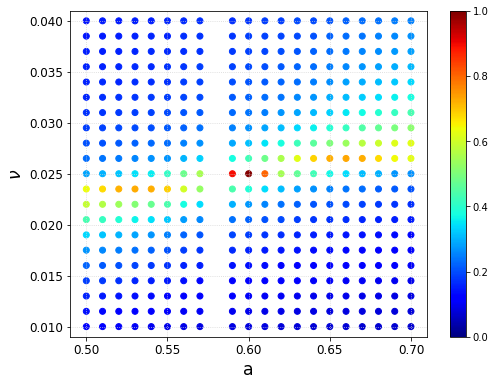

In [5]:
x = a
y = nu
z = hp_match

cmap = matplotlib.cm.get_cmap('jet')#viridis
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)
colors = [cmap(normalize(value)) for value in z]



fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.scatter(x, y, color=colors)
ax.set_xlabel("a",fontsize = 'xx-large')
ax.set_ylabel("$\\nu$",fontsize = 'xx-large')
ax.set_xlim([0.49,0.71])
ax.set_ylim([0.01-0.001,0.04 + 0.001])
#ax.set_title("hp_match")
plt.xticks([0.5,0.55,0.6,0.65,0.7],fontsize = 'large')
plt.yticks([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04],fontsize = 'large')

# Optionally add a colorbar
cax, item = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

ax.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")

#ax.set_tight_layout()
plt.savefig('hp_match.pdf', format = 'pdf', dpi = 300)
plt.show()

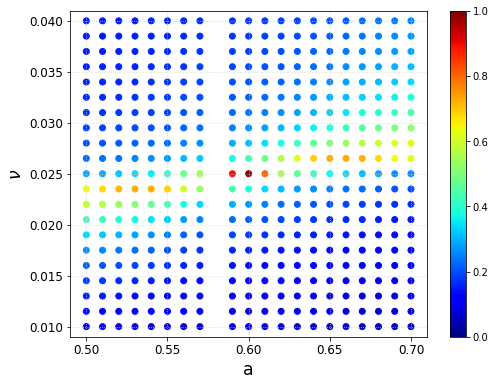

In [6]:
x = a
y = nu
z = hc_match

cmap = matplotlib.cm.get_cmap('jet')#viridis
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)
colors = [cmap(normalize(value)) for value in z]



fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.scatter(x, y, color=colors)
ax.set_xlabel("a",fontsize = 'xx-large')
ax.set_ylabel("$\\nu$",fontsize = 'xx-large')
ax.set_xlim([0.49,0.71])
ax.set_ylim([0.01-0.001,0.04 + 0.001])
#ax.set_title("hc_match")
plt.xticks([0.5,0.55,0.6,0.65,0.7],fontsize = 'large')
plt.yticks([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04],fontsize = 'large')

# Optionally add a colorbar
cax, item = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

ax.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
#plt.savefig('hc_match.pdf', format = 'pdf', dpi = 300)
#ax.set_tight_layout()
plt.show()

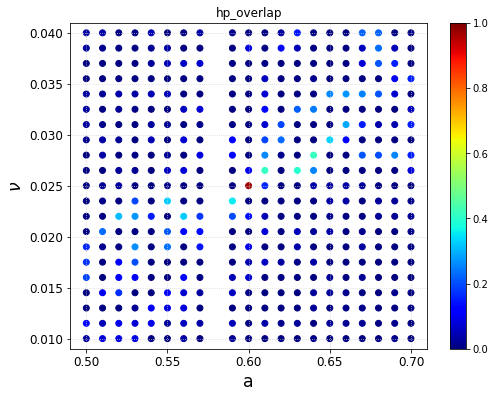

In [7]:
x = a
y = nu
z = hp_overlap

cmap = matplotlib.cm.get_cmap('jet')#viridis
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)
colors = [cmap(normalize(value)) for value in z]



fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.scatter(x, y, color=colors)
ax.set_xlabel("a",fontsize = 'xx-large')
ax.set_ylabel("$\\nu$",fontsize = 'xx-large')
ax.set_xlim([0.49,0.71])
ax.set_ylim([0.01-0.001,0.04 + 0.001])
ax.set_title("hp_overlap")
plt.xticks([0.5,0.55,0.6,0.65,0.7],fontsize = 'large')
plt.yticks([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04],fontsize = 'large')

# Optionally add a colorbar
cax, item = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

ax.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
plt.savefig('hp_overlap.pdf', format = 'pdf', dpi = 300)
#ax.set_tight_layout()
plt.show()

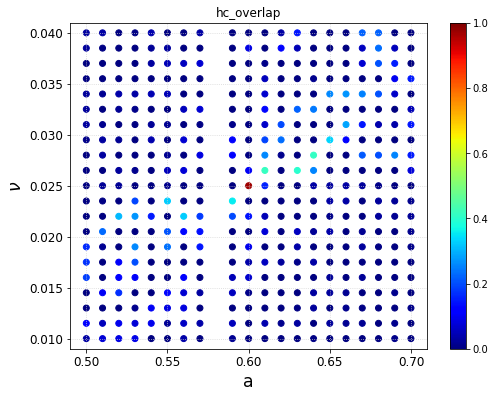

In [8]:
x = a
y = nu
z = hc_overlap

cmap = matplotlib.cm.get_cmap('jet')#viridis
normalize = matplotlib.colors.Normalize(vmin=0, vmax=1)
colors = [cmap(normalize(value)) for value in z]



fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
ax.scatter(x, y, color=colors)
ax.set_xlabel("a",fontsize = 'xx-large')
ax.set_ylabel("$\\nu$",fontsize = 'xx-large')
ax.set_xlim([0.49,0.71])
ax.set_ylim([0.01-0.001,0.04 + 0.001])
ax.set_title("hc_overlap")
plt.xticks([0.5,0.55,0.6,0.65,0.7],fontsize = 'large')
plt.yticks([0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04],fontsize = 'large')

# Optionally add a colorbar
cax, item = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalize)

ax.grid(linestyle = "dotted", color = "#d3d3d3" , which="both")
#plt.savefig('hc_overlap.pdf', format = 'pdf', dpi = 300)
#ax.set_tight_layout()
plt.show()